In [1]:
using Distributions, TimeIt, ProgressMeter, PyPlot
include("/home/postdoc/dsen/Desktop/G-ZZ/jl_files/zz_samplers.jl")
include("temp.jl")

run_sampler (generic function with 3 methods)

#### Simulate data:

In [2]:
n_groups, group_size = 25, 100
Nobs = group_size*n_groups
d = 5
dim_total = 1+n_groups+d

σ02 = 1
my_pr = MM_prior(d, n_groups, σ02);

In [3]:
pX = 5e-2
X = spzeros(dim_total, Nobs)
X[1,:] = 1
for group in 1:n_groups
    X[group+1,((group-1)*group_size+1):(group*group_size)] = 1
end
X[n_groups+2:end,:] = sprandn(d, Nobs, pX)
ξ_true = rand(Normal(),dim_total)
y = Float64.([rand(Binomial(1, 1/(1+exp(-ξ_true'X[:,j])))) for j in 1:Nobs])
my_ll = ll_logistic_sp(X,y)
my_model = model(my_ll, my_pr);

#### Run sampler:

In [4]:
mb_size = 1
max_attempts = 10^7
prob_het = 0.99
adapt_speed = "none"

lambda = 2e2
start = time()
Print = true
run_sampler(my_model, lambda, max_attempts, mb_size, Print, prob_het, adapt_speed)
print("Time = ", round((time()-start)/60,1), " mins")

10 percent attempts in 2.35 min; zz bounces = 98634, hyp bounces = 17582, total time of process = 87.225 
20 percent attempts in 4.85 min; zz bounces = 196341, hyp bounces = 34866, total time of process = 174.593 
30 percent attempts in 7.45 min; zz bounces = 294328, hyp bounces = 52433, total time of process = 261.834 
40 percent attempts in 10.10 min; zz bounces = 393286, hyp bounces = 69936, total time of process = 348.810 
50 percent attempts in 12.89 min; zz bounces = 491554, hyp bounces = 87549, total time of process = 436.141 
60 percent attempts in 15.70 min; zz bounces = 589834, hyp bounces = 105007, total time of process = 523.230 
70 percent attempts in 18.54 min; zz bounces = 689098, hyp bounces = 122382, total time of process = 610.297 
80 percent attempts in 21.43 min; zz bounces = 788078, hyp bounces = 139611, total time of process = 697.515 
90 percent attempts in 24.26 min; zz bounces = 887279, hyp bounces = 156937, total time of process = 784.755 
100 percent attempts

### Plot ACFs:

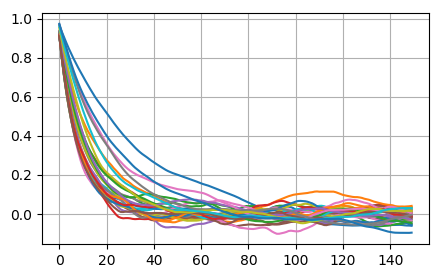

In [5]:
fig = figure("pyplot_barplot",figsize=(5,3))
n_samples = 10^4
maxlag_gzz = 150
acfs_gzz = zeros(dim_total,maxlag_gzz)
discard = 0
filename = "/xtmp/GZZ_data/mixed_effects/lambda:"*string(lambda)*
        "-dim_cov:"*string(d)*"-n_groups:"*string(n_groups)*
        "-Nobs:"*string(Nobs)*"-mb_size:"*string(mb_size)*".jld"
xt_skel, bt_skel = load(filename, "xt_skeleton", "bt_skeleton")
xi_samples_gzz = extract_samples(xt_skel[:,discard+1:end], 
                                 bt_skel[:,discard+1:end], 
                                 (bt_skel[end]-bt_skel[discard+1])/n_samples,
                                 "linear")[:,1:end-1]
for dim in 1:size(xi_samples_gzz,1)
    a = acf(xi_samples_gzz[dim,:],maxlag_gzz)
    plot(a)
    acfs_gzz[dim,:] = a
end
grid(true)
xt_skel, bt_skel, xi_samples = [], [], []
gc()

### Tune HMC:

In [6]:
ξ0 = randn(dim_total)
Total_time = 5
T = 250
Metropolise = false
Print = false
n_leapfrog_list = 20*(1:5)

20:20:100

In [7]:
for (i,n_leapfrog) in enumerate(reverse(n_leapfrog_list))
    start = time()
    prior = MM_prior(d, n_groups, σ02)
    my_ll = ll_logistic_sp(X,y)
    my_model = model(my_ll, prior)
    stepsize = Total_time/n_leapfrog
    xi_samples, hyper_samples, acc = 
    GibbsHMC(my_model, ξ0, stepsize, n_leapfrog, T, Metropolise, Print)
    print("n_leapfrog = ", n_leapfrog, " in ", round((time()-start)/60,2), " mins \n")
end

HMC acceptance = 100.0 percent; n_leapfrog = 100 in 0.83 mins 
HMC acceptance = 100.0 percent; n_leapfrog = 80 in 0.66 mins 


LoadError: [91mArgumentError: Gamma: the condition α > zero(α) && θ > zero(θ) is not satisfied.[39m

In [8]:
Metropolise = true 
Print = false

stepsize = Total_time/70
total_times = 4*stepsize*(6:15)
n_leapfrog_steps = 5*(3:10)

for total_time in total_times
    print("Total time = ", round(total_time,2), "\n")
    for n_leapfrog in n_leapfrog_steps
        start = time()
        prior = MM_prior(d, n_groups, σ02)
        my_ll = ll_logistic_sp(X,y)
        my_model = model(my_ll, prior)
        a, b, c = 
        GibbsHMC(my_model, ξ0, total_time/n_leapfrog, n_leapfrog, 500, Metropolise, Print)
        print("n_leapfrog = ", n_leapfrog, " in ", round((time()-start)/60,2), " mins \n")
        if c > 0.7 
            break
        end
    end
end

Total time = 1.71
HMC acceptance = 0.0 percent; n_leapfrog = 15 in 0.26 mins 
HMC acceptance = 17.4 percent; n_leapfrog = 20 in 0.34 mins 
HMC acceptance = 78.4 percent; n_leapfrog = 25 in 0.43 mins 
Total time = 2.0
HMC acceptance = 0.2 percent; n_leapfrog = 15 in 0.26 mins 
HMC acceptance = 0.4 percent; n_leapfrog = 20 in 0.34 mins 
HMC acceptance = 66.6 percent; n_leapfrog = 25 in 0.42 mins 
HMC acceptance = 88.0 percent; n_leapfrog = 30 in 0.51 mins 
Total time = 2.29
HMC acceptance = 0.0 percent; n_leapfrog = 15 in 0.26 mins 
HMC acceptance = 0.4 percent; n_leapfrog = 20 in 0.34 mins 
HMC acceptance = 0.6 percent; n_leapfrog = 25 in 0.43 mins 
HMC acceptance = 60.0 percent; n_leapfrog = 30 in 0.5 mins 
HMC acceptance = 92.8 percent; n_leapfrog = 35 in 0.58 mins 
Total time = 2.57
HMC acceptance = 0.0 percent; n_leapfrog = 15 in 0.26 mins 
HMC acceptance = 0.4 percent; n_leapfrog = 20 in 0.34 mins 
HMC acceptance = 0.4 percent; n_leapfrog = 25 in 0.42 mins 
HMC acceptance = 18.0 pe

LoadError: [91mInterruptException:[39m

In [9]:
total_times_optimal = round.(total_times,2)
n_leapfrog_optimal =  [23,25,31,34,37,41,45,47,1,1];

In [10]:
T = 5000
Metropolise = true
Print = false

for (i,total_time) in enumerate(total_times_optimal) 
    n_leapfrog = n_leapfrog_optimal[i]
    start = time()
    prior = MM_prior(d, n_groups, σ02)
    my_ll = ll_logistic_sp(X,y)
    my_model = model(my_ll, prior)
    xi_samples_hmc, hyper_samples_hmc, acc =
    GibbsHMC(my_model, ξ0, total_time/n_leapfrog, n_leapfrog, T, Metropolise, Print)
    print("n_leapfrog = ", n_leapfrog, " in ", round((time()-start)/60,2), " mins \n")
    filename  = "/xtmp/GZZ_data/mixed_effects/GibbsHMC:d:"*
                string(d)*"-n_groups:"*string(n_groups)*"-Nobs:"*string(Nobs)*
                "-total_time:"*string(total_time)*"-n_leapfrog:"*string(n_leapfrog)*".jld"
    save(filename, "xi_samples", xi_samples_hmc, "hyper_samples", hyper_samples_hmc, "acc", acc)
    xi_samples_hmc, hyper_samples_hmc, acc = [], [], []
    gc()
end

HMC acceptance = 71.84 percent; n_leapfrog = 23 in 3.93 mins 
HMC acceptance = 66.96 percent; n_leapfrog = 25 in 4.22 mins 
HMC acceptance = 77.1 percent; n_leapfrog = 31 in 5.22 mins 
HMC acceptance = 68.7 percent; n_leapfrog = 34 in 5.5 mins 
HMC acceptance = 66.94 percent; n_leapfrog = 37 in 5.95 mins 
HMC acceptance = 70.54 percent; n_leapfrog = 41 in 6.59 mins 
HMC acceptance = 63.2 percent; n_leapfrog = 45 in 7.19 mins 
HMC acceptance = 62.34 percent; n_leapfrog = 47 in 7.49 mins 
HMC acceptance = 0.0 percent; n_leapfrog = 1 in 0.33 mins 
HMC acceptance = 0.0 percent; n_leapfrog = 1 in 0.33 mins 


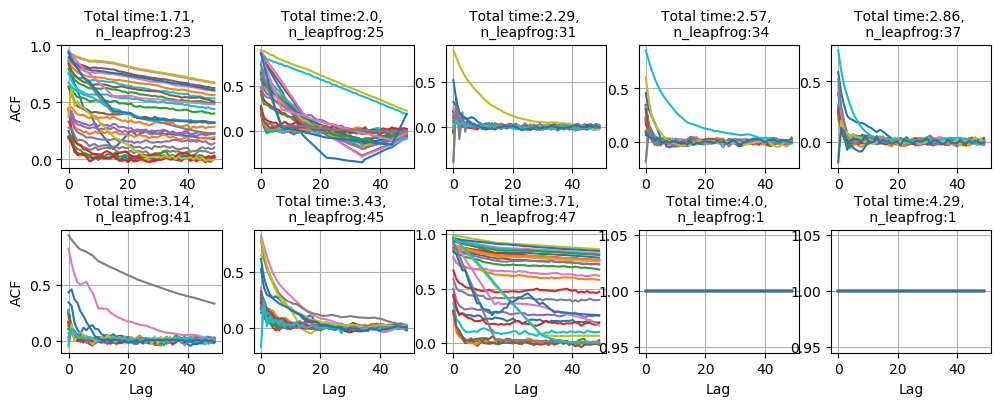

In [11]:
maxlag_hmc = 50
fig = figure(figsize=(12,4))
acfs_hmc = zeros(length(total_times_optimal),dim_total,maxlag_hmc)

for i in 1:2 
    for j in 1:5
        k = 5*(i-1)+j
        total_time, n_leapfrog = total_times_optimal[k], n_leapfrog_optimal[k]
        filename  = "/xtmp/GZZ_data/mixed_effects/GibbsHMC:d:"*
                string(d)*"-n_groups:"*string(n_groups)*"-Nobs:"*string(Nobs)*
                "-total_time:"*string(total_time)*"-n_leapfrog:"*string(n_leapfrog)*".jld"
        xi_samples_hmc = load(filename, "xi_samples")

        subplot(2,5,k)
        for dim in 1:size(xi_samples_hmc,1) 
            a = acf(xi_samples_hmc[dim,:], maxlag_hmc)
            plot(a)
            acfs_hmc[k,dim,:] = a
        end
        grid(true)  
        title("Total time:"*string(total_time)*", \n n_leapfrog:"*string(n_leapfrog), fontsize=10)
        xi_samples_hmc = []
        gc()
        if i == 2 xlabel("Lag") end
        if j == 1 ylabel("ACF") end
        subplots_adjust(hspace=0.5)
    end
end

In [12]:
T = 5000
maxlag_hmc_list = [50, 50, 40, 45, 20, 50, 50, 50, 25, 25]
hmc_mixing = zeros(length(total_times_optimal))
for i in 1:length(total_times_optimal)
    hmc_mixing[i] = T/maximum(sum(acfs_hmc[i,:,1:maxlag_hmc_list[i]],2))
end
hmc_cost = T*n_leapfrog_optimal*Nobs;

In [13]:
gzz_mixing = n_samples/maximum(sum(acfs_gzz[:,1:100],2))
gzz_cost = max_attempts*mb_size
minimum((gzz_mixing/gzz_cost)./(hmc_mixing./hmc_cost))

NaN

In [14]:
(gzz_mixing/gzz_cost)./(hmc_mixing./hmc_cost)

10-element Array{Float64,1}:
  79.7656
  61.1069
  24.4811
  26.5612
  11.5239
 100.866 
  32.6744
 186.467 
 NaN     
 NaN     

In [43]:
k=5
total_time, n_leapfrog = total_times_optimal[k], n_leapfrog_optimal[k]
filename  = "/xtmp/GZZ_data/mixed_effects/GibbsHMC:d:"*
        string(d)*"-n_groups:"*string(n_groups)*"-Nobs:"*string(Nobs)*
        "-total_time:"*string(total_time)*"-n_leapfrog:"*string(n_leapfrog)*".jld"
xi_samples_hmc, hyper_samples_hmc = load(filename, "xi_samples", "hyper_samples");

In [44]:
size(xi_samples_hmc)

(16, 5001)

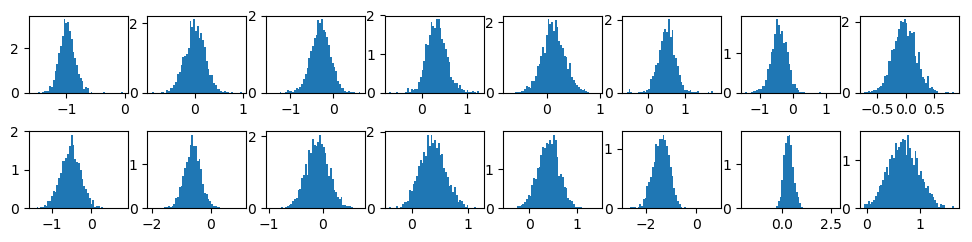

In [48]:
fig = figure(figsize=(12,2.5))
for i in 1:8
    for j in 1:2
        k = (j-1)*8+i
        subplot(2,8,k)
        hist(xi_samples_hmc[k,:], density=true, bins=50)
#         grid(true)
    end
end
subplots_adjust(hspace=0.5)

In [49]:
mean(xi_samples_hmc,2)

16×1 Array{Float64,2}:
 -0.984705  
  0.00396715
 -0.298673  
  0.333913  
  0.124698  
  0.506394  
 -0.415683  
 -0.02293   
 -0.522084  
 -0.620767  
 -0.0989715 
  0.375533  
  0.408167  
 -1.38292   
  0.353295  
  0.695113  

In [51]:
std(xi_samples_hmc,2)

16×1 Array{Float64,2}:
 0.135768
 0.209415
 0.231017
 0.228953
 0.212504
 0.24536 
 0.243652
 0.205863
 0.259145
 0.292029
 0.212147
 0.226505
 0.228325
 0.325404
 0.246505
 0.286129